## **Main Script for processing 2-photon imaging data**
#### **Suite2p registration and cell selection must be completed prior to running this script**
- **Section 1**: Process fluorescence traces and calculate dff and deconv activity traces 

- **Section 2**: Align the imaging data with virmen trials and save the imaging trial struct

- **Section 3**: Option to process just behavioral data into trialized structure
    

## **Section 0 : Import classes, and dataset specific values**

#### **0.1 -** Load local functions and static variables

In [1]:
# MUST BE RUN FIRST
import numpy as np
import os 
import platform
import matplotlib as plt
import sys

# Configure matplotlib for inline plotting in notebook
%matplotlib widget

# LOCAL FUNCTIONS & STATIC VARIABLES
def create_info_dict(mouseID, date, full_server,experimenter,sync_name,initials,virmen_channel,imaging_channel,short_mouse_name_virmen,sync_in_mouse_folder):
    """
    Creates 
     
       dictionary from mouseID and date.
    
    Args:
        mouseID (str): Mouse identifier (e.g., 'IS-3-1R')
        date (str): Date in format 'YYYY-MM-DD'
    """
    # Convert YYYY-MM-DD to YYMMDD for virmen path
    short_date = date[2:].replace('-', '')  # Takes '2024-10-29' -> '241029'
    short_mouse = mouseID[:2]
    short_mouse = short_mouse + mouseID[3]

    if sync_in_mouse_folder == 1:
        sync_base_path = f"{full_server}\{experimenter}\RawData\{mouseID}\{sync_name}\{date}"
    else:
        sync_base_path = f"{full_server}\{experimenter}\{sync_name}\{mouseID}\{date}"

    if short_mouse_name_virmen == 1:
        virmen_base = f"{full_server}\{experimenter}\RawData\{mouseID}\\virmen\{initials}{short_mouse}_{short_date}"
    else: 
        virmen_base =  f"{full_server}\{experimenter}\RawData\{mouseID}\\virmen\{initials}{mouseID}_{short_date}"
    
    info = {
        "mousename": mouseID,
        "mouse": mouseID,
        "date": date,
        "server": full_server,
        "experimenter_name": experimenter,
        "sync_base_path": sync_base_path,
        "virmen_base": virmen_base,
        "imaging_base_path": f"{full_server}\{experimenter}\RawData\{mouseID}\{date}\TSeries",
        "save_path": f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}",
        "processed_path": f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}\spikes",
        "galvo_channel": imaging_channel,  
        "virmen_channel": virmen_channel,
        "vr_sync_string": "sync_"
    }
    return info

def save_imaging_data(imaging_dict, save_path):
    """
    Save the imaging dictionary and create a list of trials with imaging data
    
    Args:
        imaging_dict (dict): Dictionary containing trial data
        save_path (str): Path where to save the files
    
    Returns:
        list: List of trial numbers that have imaging data
    """
    import pickle
    
    # Find trials with imaging data
    imaged_trials = []
    for trial_key, trial_data in imaging_dict.items():
        # Check if either deconv or dff contains data (is not None and not empty)
        if (('deconv' in trial_data and trial_data['deconv'] is not np.NaN and 
             len(trial_data['deconv']) > 0) or
            ('dff' in trial_data and trial_data['dff'] is not np.NaN and 
             len(trial_data['dff']) > 0)):
            # Extract trial number from key (e.g., 'trial_1' -> 1)
            trial_num = int(trial_key.split('_')[1])
            imaged_trials.append(trial_num)
    
    # Sort the trials numerically
    imaged_trials = sorted(imaged_trials)
    
    # Save the full dictionary
    p = os.path.join(save_path, 'imaging_data.pkl')
    with open(p, 'wb') as f:
        pickle.dump(imaging_dict, f)
    
    # Save the list of imaged trials
    p = os.path.join(save_path, 'imaged_trials.pkl')
    with open(p, 'wb') as f:
        pickle.dump(imaged_trials, f)

def range_normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))       

# Load conditions per speakers
if platform.system() == 'Windows':
    runyan5 = f"//runyan-fs-02.bns.pitt.edu/Runyan5"
    runyan4 = f"//runyan-fs-02.bns.pitt.edu/Runyan4"
    runyan3 = f"//runyan-fs-01.bns.pitt.edu/Runyan3"
else:
    runyan4 = "/Volumes/Runyan4"
    runyan5 = "/Volumes/Runyan5"
    runyan3 = "/Volumes/Runyan3"

#### **0.2 -** Initialize classes, and input dataset specific values

In [4]:
# IMPORTING FUNCTIONS FROM process_neural_data CLASS
from process_neural_data import *
deconv = deconvolution()
align = alignment()
processing = data_processing()

# CHANGE THESE FOR APPROPRIATE PATHS
mouseID = 'JE-2-00'
date = '2025-04-10'
server =  f"//runyan-fs-01.bns.pitt.edu/Runyan3"
experimenter = 'John'
initials = 'JM'
sync_type = 'Clampx'
full_server = runyan3 #f"//runyan-fs-02.bns.pitt.edu/Akhil Data"

# Change this to wherever the github repository is on your local computer
code_directory = f'C:\\Users\\RUNYAN1\\OneDrive - University of Pittsburgh\\Documents\\GitHub\\Runyan_lab_data_alignment_python'

sync_in_mouse_folder = 0 # set to 1 if sync files are stored separately in each mouse's folder
short_mouse_name_virmen = 0 # set to 1 if virmen files are under abbreviated mouse name e.g. 'IU1' instead of 'IU-1-00' 

virmen_channel = 5 # set to the analogue input channel where virmen iterations are being recorded
imaging_channel = 4 # set to the analogue input channel where the imaging y galvo is being recorded 

sys.path.append(code_directory)
save_directory = f"{server}\{experimenter}\ProcessedData\{mouseID}\{date}\spikes"

# Make save directory and cd to it
if not(os.path.exists(save_directory)):
    os.makedirs(save_directory)
os.chdir(save_directory)

## **Section 1 : DFF and Deconvolve**

#### **1.1 -** Calculate dff and deconvolved neural activity

In [5]:
# CALCULATE DFF AND DECONV AND SAVE RESULTS
# NO USER INPUT REQUIRED
info = create_info_dict(
    mouseID=mouseID,
    date= date,
    full_server = full_server,
    experimenter = experimenter,
    sync_name = sync_type,
    initials = initials,
    virmen_channel = virmen_channel,
    imaging_channel = imaging_channel,
    short_mouse_name_virmen=short_mouse_name_virmen,
    sync_in_mouse_folder=sync_in_mouse_folder)

F_file = 'Fall'
variables_to_load = ['F', 'Fneu', 'iscell']

# calculates the dff
# 225 is a constant parameter not entirely sure of function
# celi = s2p index of the cells in the dff matrix IMPORTANT 
dff, z_dff, celi = deconv.pydff(mouseID, date, server, 225, F_file, variables_to_load, 'JM',info)

# calculates deconv based on dff traces 
denoisesig, deconvsig, dff_interp, options = deconv.decovolve(dff)


\\runyan-fs-01.bns.pitt.edu\Runyan3\John\ProcessedData\JE-2-00\2025-04-10\suite2p\plane0
loaded Fall


#### **1.2 -** Save dff and deconvolved traces

In [ ]:
# Organize and save full deconv and dff traces
processed_activity = {
    'deconv' : deconvsig,
    'dff' : dff, 
    'z_dff' : z_dff,
    'celi' : celi
}
hdf5storage.savemat(os.path.join(save_directory,'activity_py.mat'),processed_activity, format='7.3', oned_as='column',truncate_existing=True)
# Save the list of imaged trials

with open(f'{save_directory}/processed_activity_py.pkl', 'wb') as f:
    pickle.dump(processed_activity, f)

## **Section 2 : Imaging Alignment with Virmen**

#### **2.1 -** Load virmen data, intialize task information

In [6]:
# ALL VALUES SET IN SECTION 0.2
info = create_info_dict(
    mouseID=mouseID,
    date= date,
    full_server = full_server,
    experimenter = experimenter,
    sync_name = sync_type,
    initials = initials,
    virmen_channel = virmen_channel,
    imaging_channel = imaging_channel,
    short_mouse_name_virmen=short_mouse_name_virmen,
    sync_in_mouse_folder=sync_in_mouse_folder)

# Sound info - should be constant, currently not used
# sound_info = {
#     "spkr_channel_number": [3, None],
#     "speaker_ids": [1, 2],
#     "mult_spkr": 0
# }


In [7]:
info['virmen_base']

'//runyan-fs-01.bns.pitt.edu/Runyan3\\John\\RawData\\JE-2-00\\virmen\\JMJE-2-00_250410'

#### **2.2 -** Create Imaging structure by parsing frames and virmen iterations

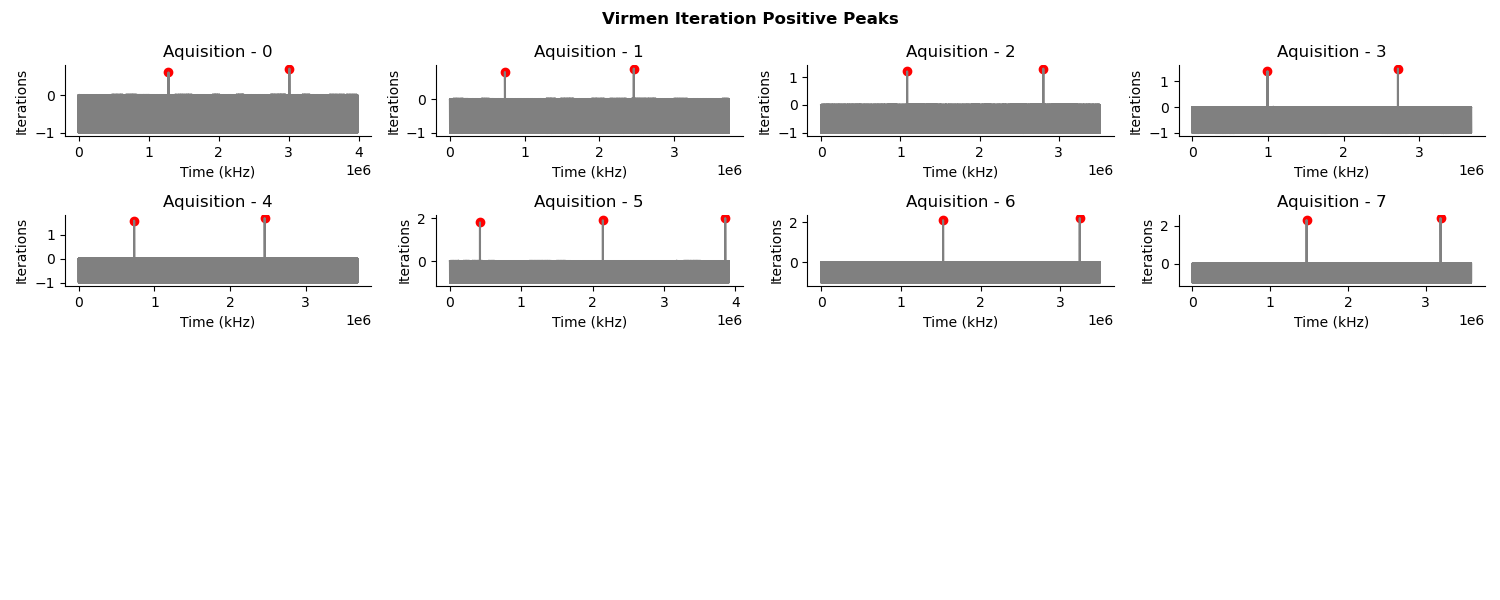

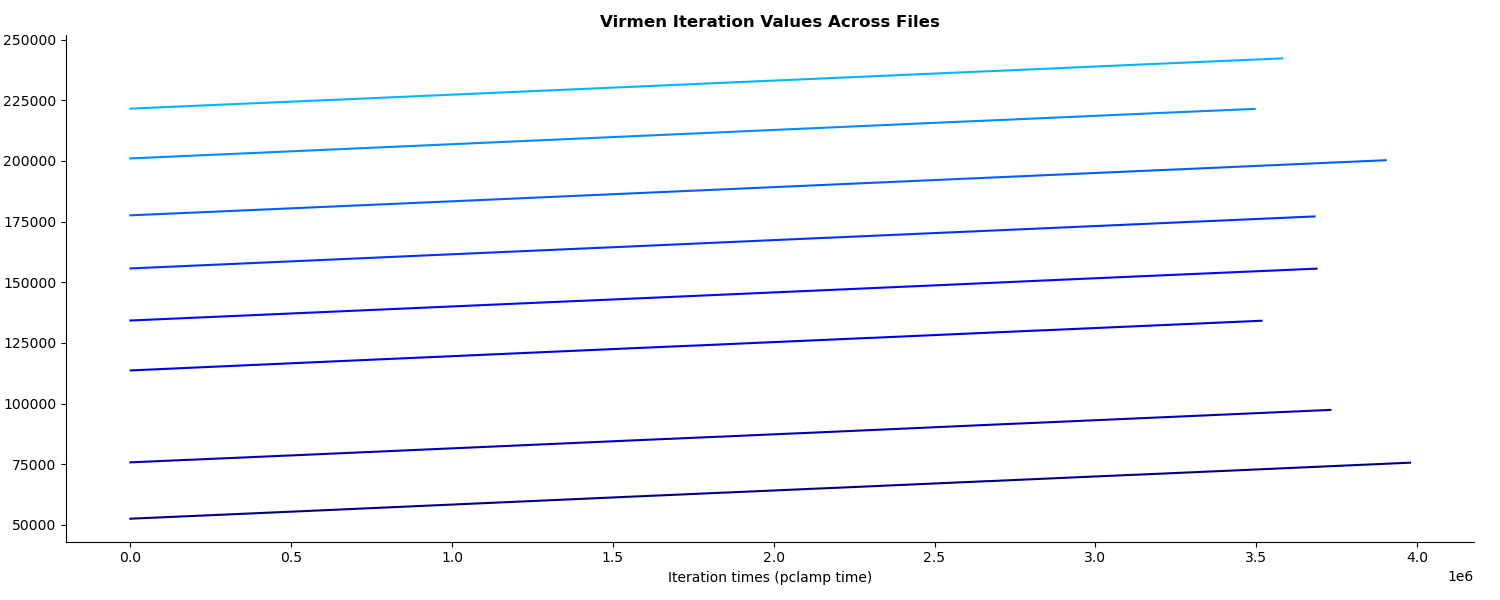

Positive peaks in VIRMEN are separated by 10k iterations. VIRMEN data successfully aligned


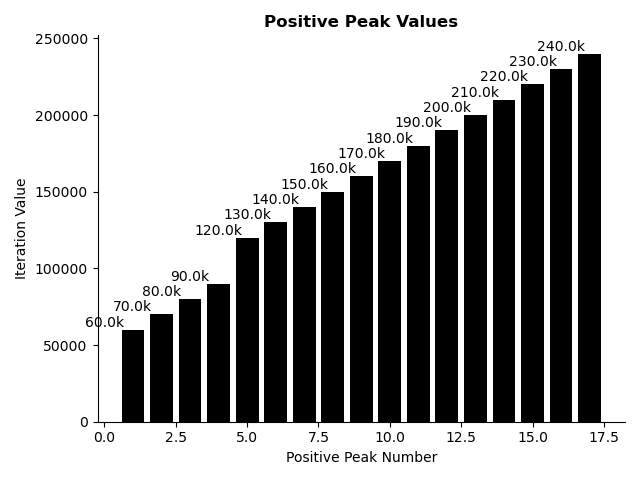

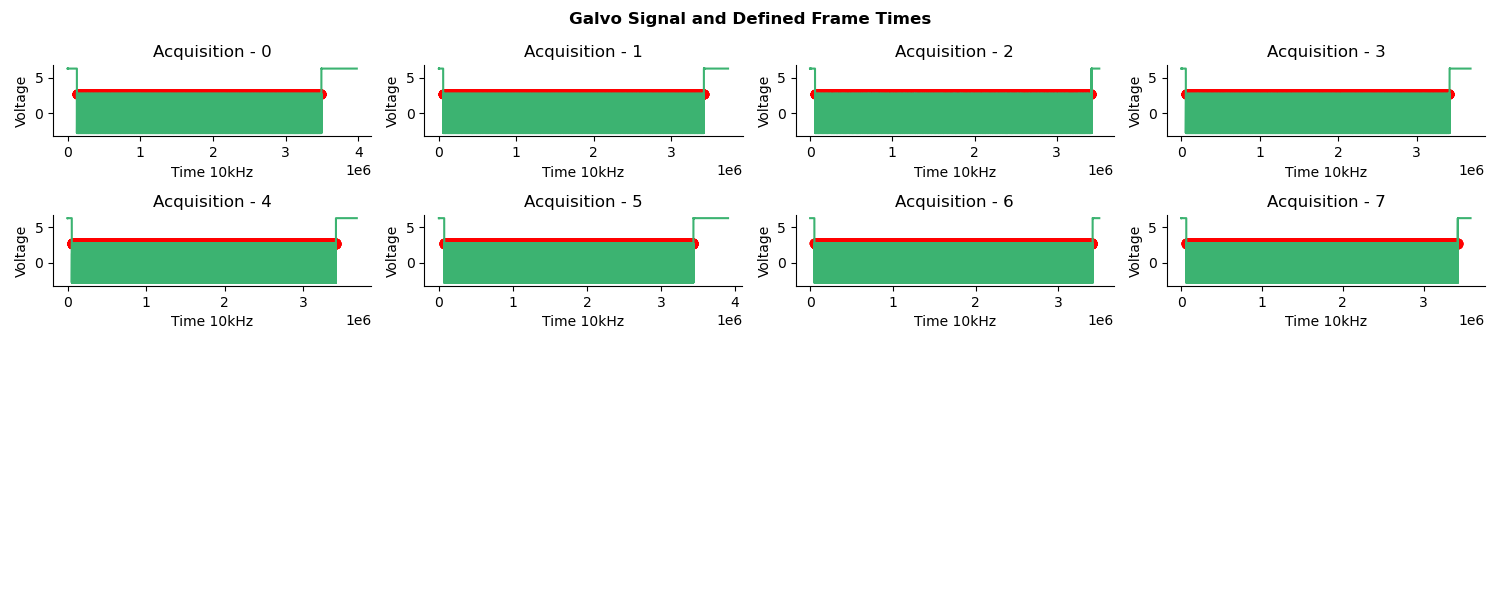

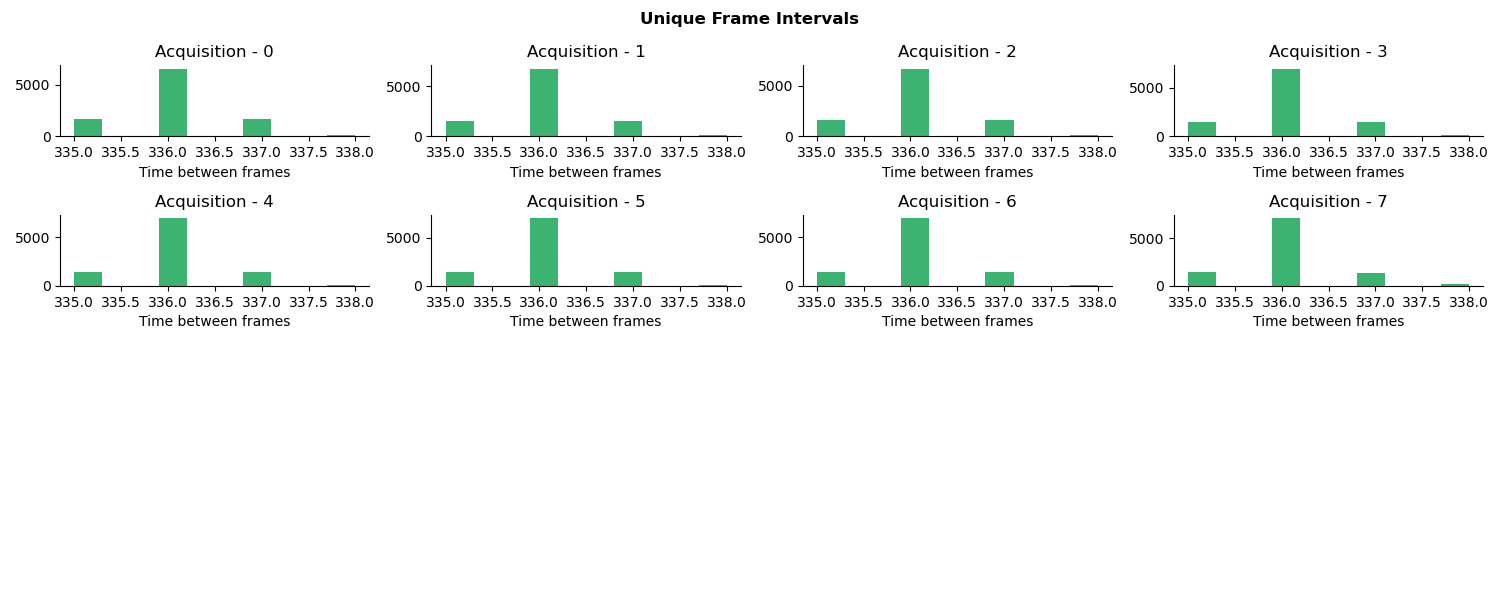

In [8]:
# Load the neural activity 
act = os.path.join(info['save_path'],'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)
deconv = activity['deconv']
dff = activity['dff']

# Load the virmen data and align virmen data to digidata
dataCell, data = align.load_virmen_data(info)
virmen_acq = align.align_virmen_iterations_to_digidata(info['sync_base_path'], info['virmen_channel'])

# Align frame times with digidata 
# alignment_info = align.get_frame_times(info["imaging_base_path"], info["sync_base_path"], info["galvo_channel"], plot_on=1)
alignment_info = align.get_frame_times_parallel(info["imaging_base_path"], info["sync_base_path"], info["galvo_channel"], plot_on=1)

# Combine frame time alignment with virmen alignment to create a trialized data structure 
# with virmen data and imaging data combined
imaging = align.align_virmen_data(dff, deconv, virmen_acq, alignment_info, data, dataCell)

# Add the sound information to the imaging structure, last two inputs are speaker channel numbers
# add channel numbers only if you are recording the sounds
imaging = align.sound_alignment_imaging(imaging, alignment_info, info['sync_base_path'],3,None)

# Package frame ids for spiral code, not used unless for debugging if not processing stimulations
frame_times_list = []
for ii in range(len(alignment_info)):
    frame_times_list.append(alignment_info[ii]['frame_times'])


#### **2.3 -** Save imaging trial structure to .mat and .pkl

In [ ]:
# SAVE THE DATA TO .mat and .pkl
save_path = info['save_path']
imaging_sorted = {}
prefix = 'Trial_'

# Add zero buffers to trial numbers of 1,2 digits (helps with matlab sorting)
for k in imaging:
    dict_key = f"{prefix}{int(k.split('_')[1]):03}"
    imaging_sorted[dict_key] = imaging[k]

# Organize and save imaging structure
imaging_sorted = {
    'imaging_sorted' : imaging_sorted
}

hdf5storage.savemat(os.path.join(save_path,'imaging_py.mat'),imaging_sorted, format='7.3', oned_as='column',truncate_existing=True)
save_imaging_data(imaging, save_path)

In [10]:
imaging

{'trial_1': {'start_it': 1,
  'end_it': 918,
  'iti_start_it': 919,
  'iti_end_it': 1213,
  'virmen_trial_info': {'correct': 0,
   'left_turn': 1,
   'condition': 2,
   'iti_correct': 5,
   'iti_incorrect': 5},
  'dff': nan,
  'z_dff': nan,
  'deconv': nan,
  'relative_frames': nan,
  'file_num': nan,
  'movement_in_virmen_time': nan,
  'frame_id': nan,
  'movement_in_imaging_time': nan,
  'good_trial': nan},
 'trial_2': {'start_it': 1214,
  'end_it': 1976,
  'iti_start_it': 1977,
  'iti_end_it': 2271,
  'virmen_trial_info': {'correct': 1,
   'left_turn': 0,
   'condition': 2,
   'iti_correct': 5,
   'iti_incorrect': 5},
  'dff': nan,
  'z_dff': nan,
  'deconv': nan,
  'relative_frames': nan,
  'file_num': nan,
  'movement_in_virmen_time': nan,
  'frame_id': nan,
  'movement_in_imaging_time': nan,
  'good_trial': nan},
 'trial_3': {'start_it': 2272,
  'end_it': 2927,
  'iti_start_it': 2928,
  'iti_end_it': 3220,
  'virmen_trial_info': {'correct': 0,
   'left_turn': 1,
   'condition': 2

## **Section 3 : Trialize virmen behavior**

#### **3.1 -** Load virmen data and create behavior structure

In [ ]:
# set missing values to None when inputting dataset specific values (eg imaging channel)
# these variables should not be accessed
info = create_info_dict(
    mouseID=mouseID,
    date= date,
    full_server = full_server,
    experimenter = experimenter,
    sync_name = sync_type,
    initials = initials,
    virmen_channel = virmen_channel,
    imaging_channel = imaging_channel,
    short_mouse_name_virmen=short_mouse_name_virmen,
    sync_in_mouse_folder=sync_in_mouse_folder)

# Load Virmen data
dataCell, data = align.load_virmen_data(info)
virmen_acq = align.align_virmen_iterations_to_digidata(info['sync_base_path'], info['virmen_channel'])

behavior = align.align_virmen_data_behavior_only(virmen_acq, data, dataCell)


#### **3.2 -** Save behavior trial structure to .mat and .pkl

In [ ]:
# comment out and change save_path if you want to save the data somewhere else
save_path = info['save_path']
hdf5storage.savemat(os.path.join(save_path,'behavior_py.mat'),behavior, format='7.3', oned_as='column',truncate_existing=True)

p = os.path.join(save_path, 'behavior_data.pkl')
with open(p, 'wb') as f:
    pickle.dump(behavior, f)
